<h3>Training Parameters used in architecture</h3>
<ul>
    <li>TF-IDF Vectorizer: Used for extracting features</li>
    <li>PCA: Used to reduce Dimension to reduce its feature space (most features are zeros)</li>
    <li>KMeans: Used for clustering as it is a unsupervised problem</li>
    <li>POS Count: Counting of POS tags in documents</li>
    <li>Word count per document: After removal of Stopwords </li>
    <li>Elbow and Silhouette Curve: Used to determine the number of clusters</li>
</ul>


In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 350)
import os
from glob import glob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

import re
from tqdm import tqdm

import pickle as pkl
from utils import *

In [128]:
def getClusterCenter(distances, names ,DatasetPath):
    """
        -------
            function to return documents at center
        -------
        distances: distances from center in kmeans
        names: names of your documents for returning
        DatasetPath: path of the folder where documents kept
        
        return document names
    """
    centers = np.argmin(distances, axis=0)
    names = np.array(names)[centers]
    _names = []
    for name in names:
        _names.append(DatasetPath+name)
    return _names

def plotClusterPCA(features, cluster_class, size=12):
    """
        -------
            Plot PCA for feature visualization. Can be made better by multiplying weigths.
            For our problem this enough.
        -------
        features: Features extracted from documents 
        cluster_class: classes for hue in plot
        size: size of plot        
    """
    
    pca = PCA(n_components=2)
    pca_features=pca.fit_transform(features)

    pca_df = pd.DataFrame(pca_features, columns=["x", "y"])
    pca_df['cluster'] = cluster_class
    sns.lmplot("x","y", data=pca_df, hue="cluster", fit_reg=False, size=size)
def checkCluster(features, _range=[4,15], _n_init=50, _max_iter=1000):
    """
        -------
            This function helps to find the best cluster number for kmeans clusting.
            To find best cluster Elbow curve and silhouette_score both calculated 
            Elbow curve: Find sudden fall
            Silhouette Score: Higher is better
            
            It will plot Elobow curve and Silhouette Score curve
        -------
        features: Features extracted from documents 
        _range: range for clustering
        _n_init: # of initial cluster centers
        _max_iter: # of iterations
    """
    n_cluster_check = range(_range[0],_range[1])
    elbow_curve = []
    silhouette_curve = []
    for c in tqdm(n_cluster_check):
        train_mini_kmean = KMeans(n_clusters=c, n_init=50, max_iter=1000)
        train_mini_kmean.fit(features)
        elbow_curve.append(train_mini_kmean.inertia_)
        silhouette_curve.append(silhouette_score(features,train_mini_kmean.labels_))


    plt.figure(figsize=(15,5))
    plt.plot(n_cluster_check,elbow_curve)
    plt.scatter(n_cluster_check,elbow_curve)
    plt.title("Elbow Curve")
    plt.show()
    plt.figure(figsize=(15,5))
    plt.plot(n_cluster_check,silhouette_curve)
    plt.scatter(n_cluster_check,silhouette_curve)
    plt.title("Silhouette Score Curve")
    plt.show()
    
def createPOSCount(corpus_list):
    """
        -------
            Return count of unique POS tags
        -------
        corpus_list: List of documents
    """
    idx = 0 
    df_values = []
    for txt in tqdm(corpus_list):
        tokens = word_tokenize(txt)
        pos_tags = dict(np.array(np.unique(list(dict(nltk.pos_tag(tokens)).values()),return_counts=True)).T)

        values = np.zeros(len(columns))

        for tag, value in pos_tags.items():
            if tag in columns:
                values[columns.index(tag)] = value
        values = list(values)
        df_values.append(values)
        idx+=1
    return df_values

In [6]:
DATASET_PATH = "./Story text files/"
stpwords = stopwords.words("english")
with open("unique_file_names.pkl", "rb") as fp:
    file_names = pkl.load(fp)

In [7]:
print("Total Documents: ", len(file_names))

Total Documents:  438


In [8]:
file_names = shuffle(file_names)
train_file_path, test_file_path = file_names[:int(len(file_names)*.90)], file_names[int(len(file_names)*.90):]

In [9]:
print("Total training documents: ",len(train_file_path))
print("Total testing documents: ",len(test_file_path))
print("Ratio test/train: {0:.2f}".format(len(test_file_path)/len(train_file_path)))

Total training documents:  394
Total testing documents:  44
Ratio test/train: 0.11


In [10]:
train_file_names = getFileNames(train_file_path)
test_file_names = getFileNames(test_file_path)
train_corpus_list = readFiles(train_file_path)
test_corpus_list = readFiles(test_file_path)

<h3>Baseline</h3>

In [11]:
train_vectorizer_v1 = TfidfVectorizer(max_df=1.0, min_df=0.0, 
                                      sublinear_tf=True, 
                                      ngram_range=(1,1), 
                                      max_features=500)

train_features_v1 = train_vectorizer_v1.fit_transform(train_corpus_list)
train_features_df_v1 = pd.DataFrame(train_features_v1.todense(),columns=train_vectorizer_v1.get_feature_names())
train_features_df_v1['file_name'] = train_file_names

100%|██████████| 16/16 [00:14<00:00,  1.06s/it]


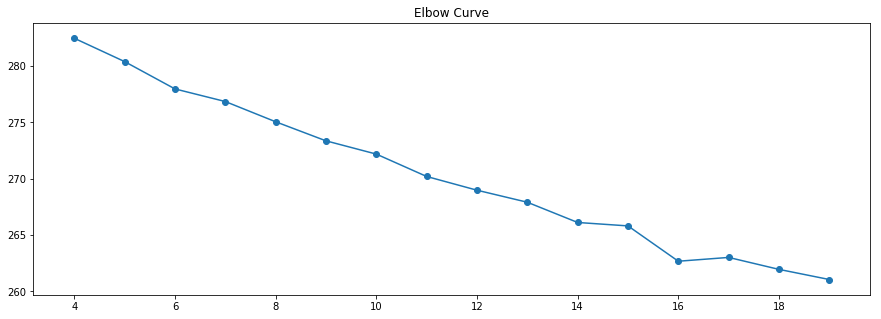

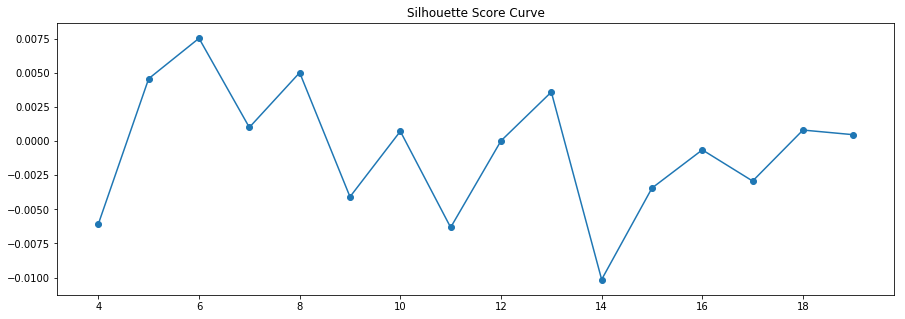

In [12]:
checkCluster(train_features_df_v1.iloc[:,:-1],_range=[4, 20], _n_init=50, _max_iter=500)

In [13]:
train_mini_kmean_v1 = KMeans(n_clusters=6, n_init=50, max_iter=500)

train_mini_kmean_v1_distances = train_mini_kmean_v1.fit_transform(train_features_df_v1.iloc[:,:-1])

train_features_df_v1['_class'] = train_mini_kmean_v1.labels_
np.transpose(np.unique(train_mini_kmean_v1.labels_, return_counts=True))

array([[ 0, 75],
       [ 1, 46],
       [ 2, 55],
       [ 3, 76],
       [ 4, 91],
       [ 5, 51]])

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


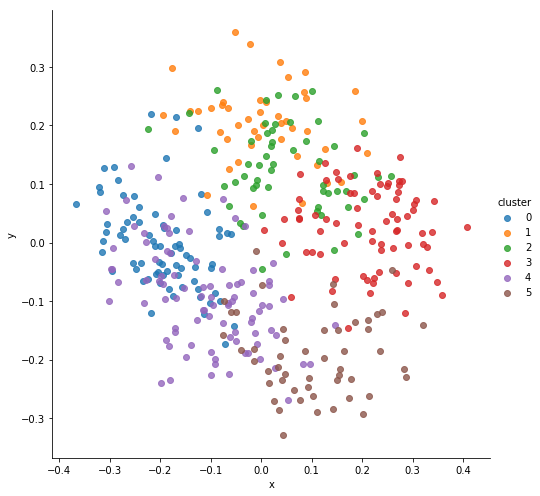

In [14]:
plotClusterPCA(train_features_df_v1.iloc[:,:-2], train_features_df_v1["_class"], size=7)

In [125]:
# train_mini_kmean_v1_centers = getClusterCenter(train_mini_kmean_v1_distances, train_features_df_v1['file_name'], DATASET_PATH)
# for doc in train_mini_kmean_v1_centers:
# #     print(DATASET_PATH+str(doc))
#     print(readFiles([doc], isRemoveSpecailchar=False, isToLower=False))
#     print()
#     print()


In [21]:
# train_docs_cat = train_features_df_v1[train_features_df_v1['_class']==1][['file_name']].values
# for doc in train_docs_cat[:6]:
#     print(readFiles(DATASET_PATH+doc, isRemoveSpecailchar=False, isToLower=False))

<h3>Model V2</h3>

In [22]:
train_vectorizer_v2 = TfidfVectorizer(max_df=1.0, min_df=0.0, 
                                      sublinear_tf=True, 
                                      ngram_range=(1,3), 
                                      max_features=300)

train_features_v2 = train_vectorizer_v2.fit_transform(train_corpus_list)
train_features_df_v2 = pd.DataFrame(train_features_v2.todense(),columns=train_vectorizer_v2.get_feature_names())
train_features_df_v2['file_name'] = train_file_names

100%|██████████| 26/26 [00:20<00:00,  1.11s/it]


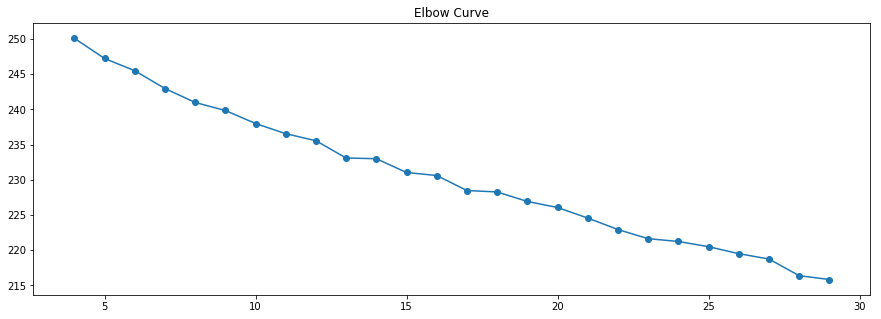

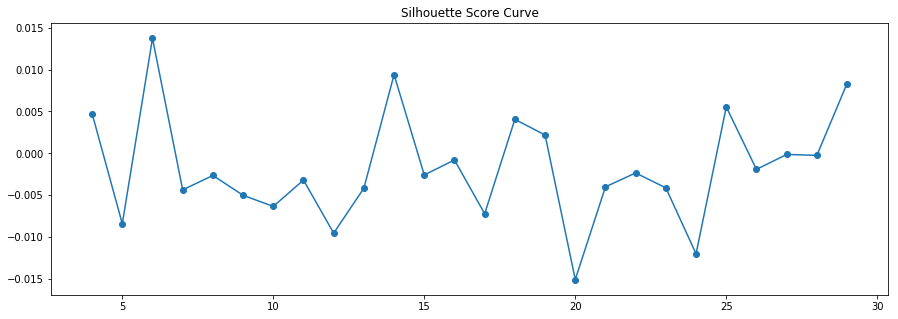

In [23]:
checkCluster(train_features_df_v2.iloc[:,:-1],_range=[4, 30], _n_init=50, _max_iter=500)

In [24]:
train_mini_kmean_v2 = KMeans(n_clusters=12, n_init=60, max_iter=500)

train_mini_kmean_v2_distances = train_mini_kmean_v2.fit_transform(train_features_df_v2.iloc[:,:-2])

train_features_df_v2['_class'] = train_mini_kmean_v2.labels_
np.transpose(np.unique(train_mini_kmean_v2.labels_, return_counts=True))

array([[ 0, 16],
       [ 1, 45],
       [ 2, 55],
       [ 3, 33],
       [ 4, 47],
       [ 5, 46],
       [ 6,  6],
       [ 7, 51],
       [ 8,  8],
       [ 9, 68],
       [10,  6],
       [11, 13]])

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


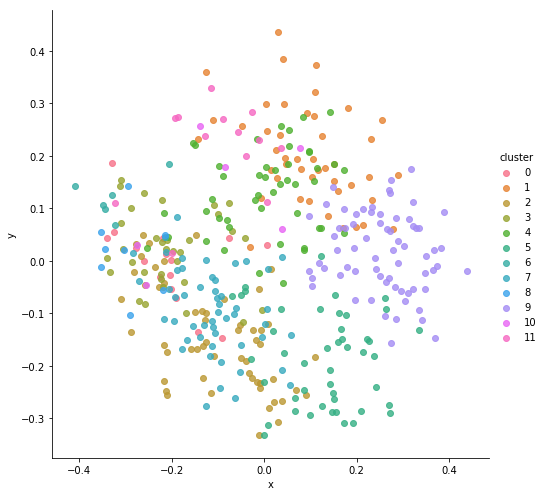

In [25]:
plotClusterPCA(train_features_df_v2.iloc[:,:-2], train_features_df_v2["_class"], size=7)

In [126]:
# train_mini_kmean_v2_centers = getClusterCenter(train_mini_kmean_v2_distances, train_features_df_v2['file_name'], DATASET_PATH)
# for doc in train_mini_kmean_v2_centers:
# #     print(DATASET_PATH+str(doc))
#     print(readFiles([doc], isRemoveSpecailchar=False, isToLower=False))
#     print()
#     print()



In [27]:
# train_docs_cat = train_features_df_v2[train_features_df_v2['_class']==2][['file_name']].values

# for doc in train_docs_cat[:6]:
#     print(readFiles(DATASET_PATH+doc, isRemoveSpecailchar=False, isToLower=False))
#     print()
#     print()

<h3>Model V3</h3>

In [47]:
train_vectorizer_v3 = TfidfVectorizer(max_df=1.0, min_df=0.10, 
                                      sublinear_tf=True, 
                                      ngram_range=(1,3), 
                                      max_features=300)

train_features_v3 = train_vectorizer_v3.fit_transform(train_corpus_list)
train_features_df_v3 = pd.DataFrame(train_features_v3.todense(),columns=train_vectorizer_v3.get_feature_names())
train_features_df_v3['file_name'] = train_file_names

100%|██████████| 16/16 [00:10<00:00,  1.28it/s]


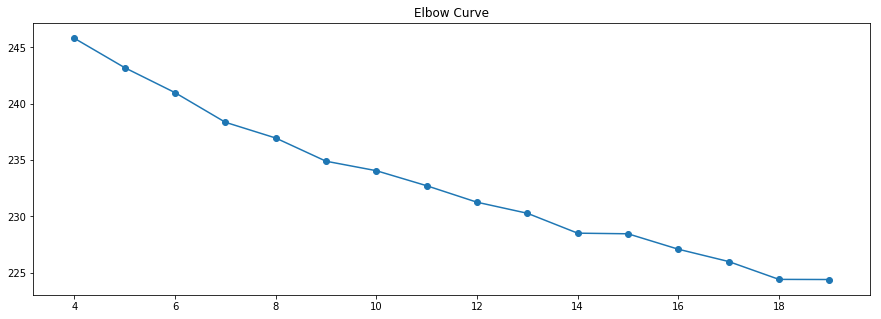

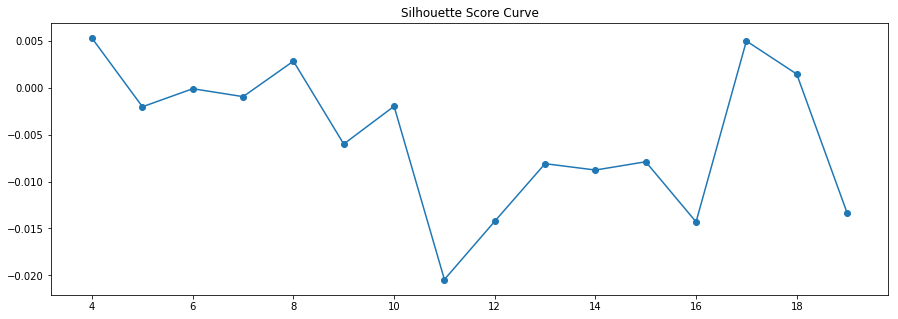

In [48]:
checkCluster(train_features_df_v3.iloc[:,:-1],_range=[4, 20], _n_init=50, _max_iter=500)

In [49]:
train_mini_kmean_v3 = KMeans(n_clusters=8, n_init=10, max_iter=500)

train_mini_kmean_v3_distances = train_mini_kmean_v3.fit_transform(train_features_df_v3.iloc[:,:-1])

train_features_df_v3['class'] = train_mini_kmean_v3.labels_
np.transpose(np.unique(train_mini_kmean_v3.labels_, return_counts=True))

array([[ 0, 37],
       [ 1, 49],
       [ 2, 89],
       [ 3, 68],
       [ 4, 57],
       [ 5, 16],
       [ 6, 40],
       [ 7, 38]])

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


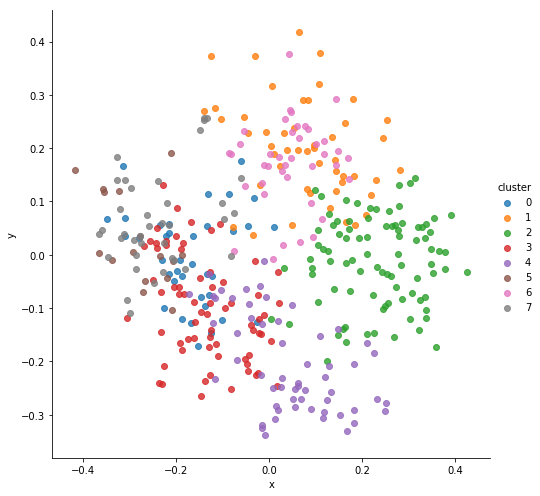

In [50]:
plotClusterPCA(train_features_df_v3.iloc[:,:-2], train_features_df_v3["class"], size=7)

In [51]:
train_mini_kmean_v3_distances = train_mini_kmean_v3.transform(train_features_df_v3.iloc[:,:-2])

In [52]:
np.argmin(train_mini_kmean_v3_distances, axis=0)

array([249, 387, 240,   5, 332,   3, 240, 278])

In [127]:
# train_mini_kmean_v3_centers = getClusterCenter(train_mini_kmean_v3_distances, train_features_df_v3['file_name'], DATASET_PATH)
# for doc in train_mini_kmean_v3_centers:
# #     print(DATASET_PATH+str(doc))
#     print(readFiles([doc], isRemoveSpecailchar=False, isToLower=False))
#     print()
#     print()

<h3>Model V4</h3>
<h4>Remove Stopwords</h4>

In [55]:
train_tokens_list_x_stpwds = removeStopwords(train_corpus_list, stopWords=stpwords, 
                                             isListOfDocs=True, isWordTokenize=True)

train_corpus_list_x_stpwds = allToString(train_tokens_list_x_stpwds, isListOfDocs=True)

In [56]:
train_vectorizer_v4 = TfidfVectorizer(max_df=1.0, min_df=0.1, 
                                      sublinear_tf=True, 
                                      ngram_range=(1,3), 
                                      max_features=10000)

train_features_v4 = train_vectorizer_v4.fit_transform(train_corpus_list_x_stpwds)
train_features_df_v4 = pd.DataFrame(train_features_v4.todense(),columns=train_vectorizer_v4.get_feature_names())
train_features_df_v4['file_name'] = train_file_names

100%|██████████| 16/16 [00:09<00:00,  1.41it/s]


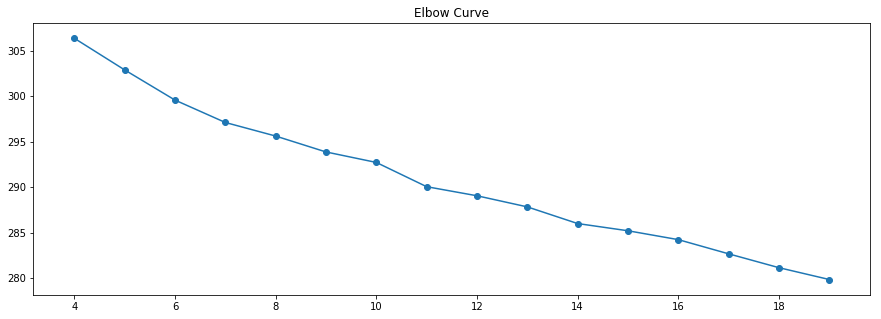

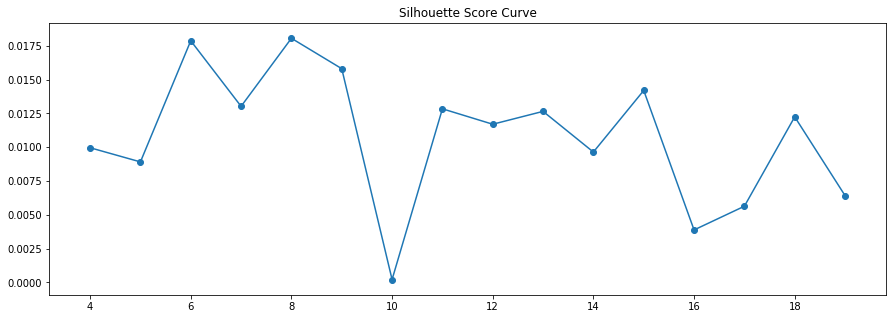

In [57]:
checkCluster(train_features_df_v4.iloc[:,:-1],_range=[4, 20], _n_init=50, _max_iter=500)

In [58]:
train_mini_kmean_v4 = KMeans(n_clusters=8, n_init=50, max_iter=1000)

train_mini_kmean_v4_distances = train_mini_kmean_v4.fit_transform(train_features_df_v4.iloc[:,:-1])

train_features_df_v4['_class'] = train_mini_kmean_v4.labels_
np.transpose(np.unique(train_mini_kmean_v4.labels_, return_counts=True))

array([[ 0, 22],
       [ 1, 98],
       [ 2, 75],
       [ 3, 14],
       [ 4, 15],
       [ 5, 11],
       [ 6, 92],
       [ 7, 67]])

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


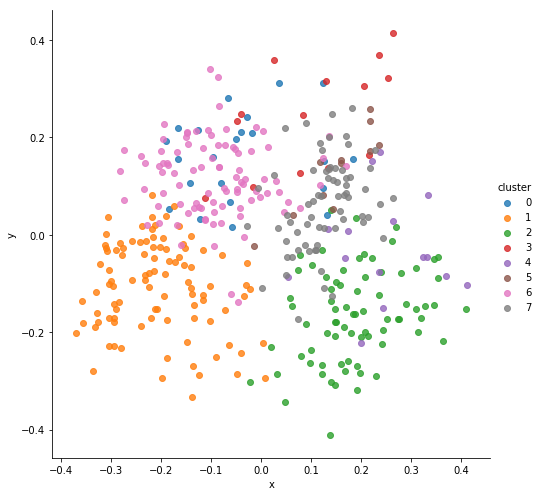

In [59]:
plotClusterPCA(train_features_df_v4.iloc[:,:-2], train_features_df_v4["_class"], size=7)

In [60]:
train_mini_kmean_v4_centers = getClusterCenter(train_mini_kmean_v4_distances, train_features_df_v4['file_name'], DATASET_PATH)
for doc in train_mini_kmean_v4_centers:
#     print(DATASET_PATH+str(doc))
    print(readFiles([doc], isRemoveSpecailchar=False, isToLower=False))
    print()
    print()

['[\'the Lion who Wouldn\\\'t Try this book belongs toIt was a sunny day in the jungle. All the animals were out playing.“Come play with me, Lion,” said Cheetah. “Catch me if you can!” zoom-zoom! went Cheetah. “I don’t want to play,” said Lion. “I’ll lose.”“Come play with me, Lion,” said Elephant. “We can throw rocks!” ka-pow! ka-pow! went Elephant. “I don’t want to play,” said Lion. “I’ll lose.”“Come play with us, Lion!” said the monkeys. “Who can eat the most bananas?” pop! pop! pop! went the monkeys. “I don’t want to play,” said Lion. “I’ll lose.”“Come play with me, Lion, " said Springbok. “Let’s jump high!” zoop! zoop! zoop! went Springbok. “I don’t want to play,” said Lion. “I’ll lose.”“Come play with me, Lion,” said Crocodile. “It’s a swimming competition!” splash! splash! went Crocodile. “I don’t want to play,” said Lion. “I’ll lose.”Crocodile was quicker than Elephant, but each time Crocodile got ahead, Elephant tickled him! tee-hee-hee! went Elephant and Crocodile. Elephant an

In [61]:
# train_docs_cat = train_features_df_v4[train_features_df_v4['_class']==1][['file_name']].values

# for doc in train_docs_cat[:6]:
#     print(readFiles(DATASET_PATH+doc, isRemoveSpecailchar=False, isToLower=False))
#     print()
#     print()

<h3>Model V5</h3>
<h4>Reducing Dimension to 300</h4>

In [62]:
train_vectorizer_v5 = TfidfVectorizer(max_df=1.0, min_df=0.0, 
                                      sublinear_tf=True, 
                                      ngram_range=(1,2), 
                                      max_features=10000)

train_features_v5 = train_vectorizer_v5.fit_transform(train_corpus_list_x_stpwds)

In [63]:
train_features_v5.shape

(394, 10000)

In [64]:
n_component = 300
train_pca_v5 = PCA(n_components=n_component)
train_features_v5_pca = train_pca_v5.fit_transform(train_features_v5.todense())

100%|██████████| 16/16 [00:07<00:00,  1.63it/s]


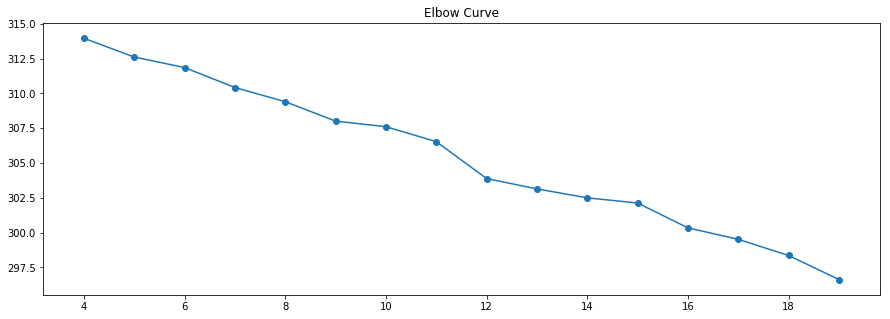

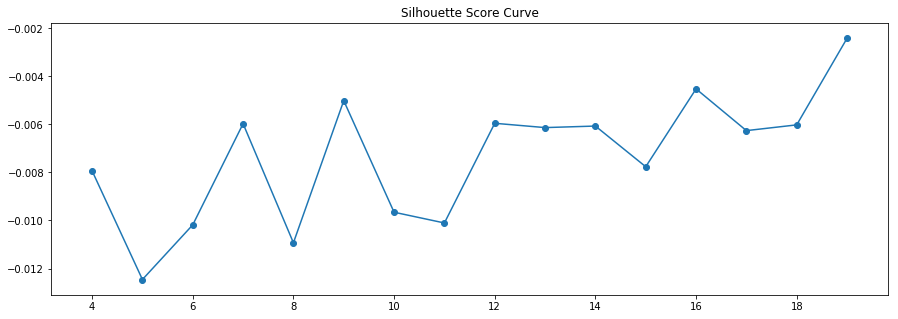

In [65]:
checkCluster(train_features_v5_pca, _range=[4, 20])

In [66]:
feature_names = ["v_"+str(v+1) for v in range(n_component)]

In [67]:

train_features_df_v5 = pd.DataFrame(train_features_v5_pca,columns=feature_names)
train_features_df_v5['file_name'] = train_file_names

train_mini_kmean_v5 = KMeans(n_clusters=9, n_init=50, max_iter=1000)

train_mini_kmean_v5_distances = train_mini_kmean_v5.fit_transform(train_features_df_v5.iloc[:,:-1])

train_features_df_v5['_class'] = train_mini_kmean_v5.labels_
np.transpose(np.unique(train_mini_kmean_v5.labels_, return_counts=True))

array([[  0,  20],
       [  1, 225],
       [  2,   2],
       [  3, 124],
       [  4,   1],
       [  5,   7],
       [  6,   4],
       [  7,   6],
       [  8,   5]])

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


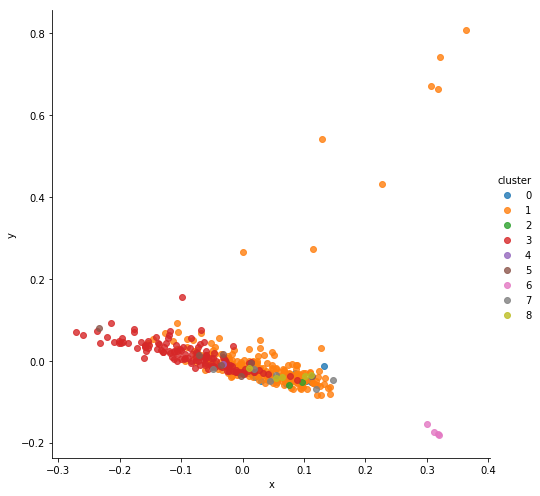

In [68]:
plotClusterPCA(train_features_df_v5.iloc[:,:-2], train_features_df_v5["_class"], size=7)

In [69]:
train_mini_kmean_v5_centers = getClusterCenter(train_mini_kmean_v5_distances, train_features_df_v5['file_name'], DATASET_PATH)
for doc in train_mini_kmean_v5_centers:
#     print(DATASET_PATH+str(doc))
    print(readFiles([doc], isRemoveSpecailchar=False, isToLower=False))
    print()
    print()

["['This is my house. Ma, Pa and Cheena also live here.The best chair in the house is for me. But sitting on the lap is even better, isn’t it?Cheena is my best friend. I wait for her to return from school.I keep myself clean without water. I do not need a bath like Tommy.Shhh. . . don’t tell anyone that I am hiding here. 1. . . 2. . . 3. . . Got you!Ma shouts at me, when I bring some tasty food from the garden.I can climb trees. I can jump. I know all the short cuts here.Sanju lives nearby. He teases me. It makes me very angry.Please tell Sanju that the tiger is from our cat family. We have sharp claws.My friends sometimes make a lot of noise at night. By then I am quietly in bed.Tails can speak! Did you know how animals and birds tell us something by using their tails? A dog wags its tail when it is happy. A cat puffs up its tail when it is angry. Often we say, “As clean as a cat” . This is because cats do not like water, yet they are always keeping themselves clean by licking themsel

In [70]:
# train_docs_cat = train_features_df_v5[train_features_df_v5['_class']==0][['file_name']].values

# for doc in train_docs_cat[:6]:
#     print(readFiles(DATASET_PATH+doc, isRemoveSpecailchar=False, isToLower=False))
#     print()
#     print()

<h3>Model V6</h3>
<h4>Adding POS tag counts and document length count as features</h4>

In [85]:
train_vectorizer_v5 = TfidfVectorizer(max_df=1.0, min_df=0.0, 
                                      sublinear_tf=True, 
                                      ngram_range=(1,3), 
                                      max_features=1000)

train_features_v5 = train_vectorizer_v5.fit_transform(train_corpus_list_x_stpwds)

In [86]:
n_component = 50
train_pca_v5 = PCA(n_components=n_component)
train_features_v5_pca = train_pca_v5.fit_transform(train_features_v5.todense())

In [87]:
feature_names = ["v_"+str(v+1) for v in range(n_component)]

100%|██████████| 16/16 [00:05<00:00,  2.15it/s]


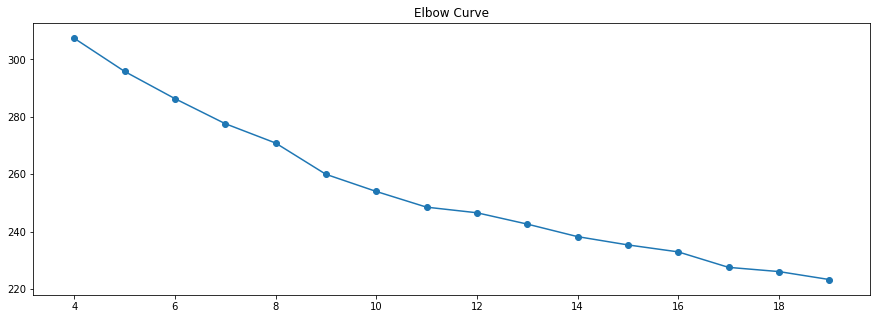

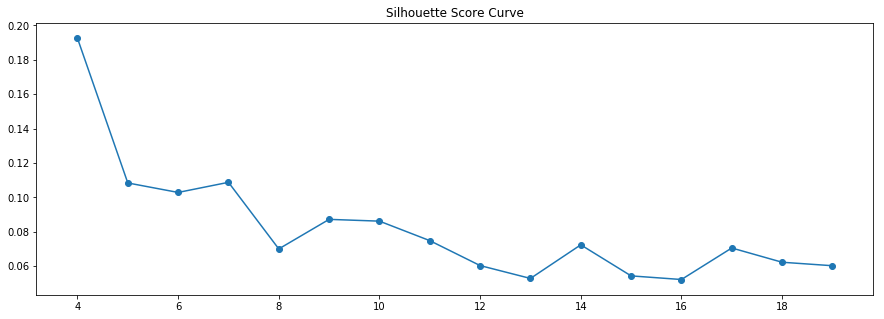

In [94]:
checkCluster(train_features_v5_pca, _range=[4, 20])

In [95]:
train_features_df_v6 = pd.DataFrame(train_features_v5_pca,columns=feature_names)
train_features_df_v6['file_name'] = train_file_names

train_mini_kmean_v6 = KMeans(n_clusters=6, n_init=50, max_iter=1000)

train_mini_kmean_v6_distances = train_mini_kmean_v6.fit_transform(train_features_df_v6.iloc[:,:-1])

train_features_df_v6['_class'] = train_mini_kmean_v6.labels_
np.transpose(np.unique(train_mini_kmean_v6.labels_, return_counts=True))

array([[  0, 102],
       [  1,  89],
       [  2, 104],
       [  3,  10],
       [  4,  81],
       [  5,   8]])

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


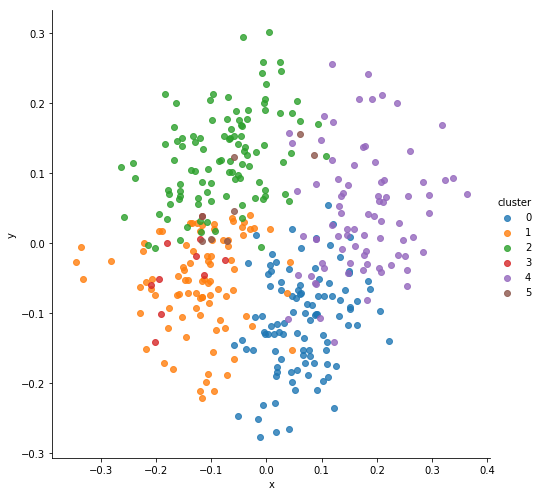

In [96]:
plotClusterPCA(train_features_df_v6.iloc[:,:-2], train_features_df_v6["_class"], size=7)

In [97]:
train_mini_kmean_v6_centers = getClusterCenter(train_mini_kmean_v6_distances, train_features_df_v6['file_name'], DATASET_PATH)
for doc in train_mini_kmean_v6_centers:
#     print(DATASET_PATH+str(doc))
    print(readFiles([doc], isRemoveSpecailchar=False, isToLower=False))
    print()
    print()

['["In the swamp on the far side of the Far Forest, lived Sniffles, the Crocodile. Sniffles was always crying big crocodile tears or going sniff. . . sniff. . . Even his mom was quite tired of him and would say, “Stop snivelling and crying, start behaving like a crocodile. Go hunt for your food.”But Sniffles would burst into tears at the thought of eating another animal. So mom and dad had to feed Sniffles every day.Sniffles did not want to be a crocodile. \'I am so ugly, \' he thought, bursting into tears. He did not even want to live like crocodiles do. His best friend was Punch, a golden yellow butterfly. And Punch wanted to be big and strong. So Punch always had her feeler curled into a fist saying, “Look out! I will punch you in the mouth.”They made a very funny pair. Sniffles swimming with Punch perched on his head. The other crocodiles would laugh and make fun of them. That did not bother Sniffles. He continued crying, sniffling and being friends with Punch.One sunny afternoon, 

<h3>Save Model V6</h3>
<h4>Model Parameters Needed</h4>
<ul>
    <li>Kmeans Model for predictions</li>
    <li>TF-IDF Vectorizer</li>
    <li>PCA for Dimensionality Reduction</li>
</ul>
<h4>Preprocess Flow</h4>
<h6>Remove Stopwords > TF-IDF vector(1000) > PCA (50) > Predict using KMeans </h6>

In [99]:
with open("./models/model_v6/tf_idf.model", "wb") as fp:
    pkl.dump(train_vectorizer_v5, fp)
with open("./models/model_v6/pca.model", "wb") as fp:
    pkl.dump(train_pca_v5, fp)
with open("./models/model_v6/kmeans.model", "wb") as fp:
    pkl.dump(train_mini_kmean_v6, fp)

In [100]:
with open("./models/test_file_names.pkl", "wb") as fp:
    pkl.dump(test_file_names, fp)

<h3>Model V7</h3>
<h4>Adding POS tag counts and document length count as features</h4>

In [106]:
train_vectorizer_v7 = TfidfVectorizer(max_df=1.0, min_df=0.1, 
                                      sublinear_tf=True, 
                                      ngram_range=(1,3), 
                                      max_features=1000)

train_features_v7 = train_vectorizer_v7.fit_transform(train_corpus_list_x_stpwds)

In [107]:
n_component = 50
train_pca_v7 = PCA(n_components=n_component)
train_features_v7_pca = train_pca_v7.fit_transform(train_features_v7.todense())

In [108]:
feature_names = ["v_"+str(v+1) for v in range(n_component)]

In [109]:
columns =['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN',
'NNP','NNPS','NNS','PDT','POS','PRP','PRP$','RB','RBR','RBS','RP',
'TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']

In [110]:
train_data_POS_count = createPOSCount(train_corpus_list_x_stpwds)
train_data_len_dict = wordsPerFile(train_corpus_list_x_stpwds, train_file_names, isRemoveStopwords=False)
train_data_len = np.array([list(train_data_len_dict.values())]).T

100%|██████████| 394/394 [00:05<00:00, 74.38it/s]


In [111]:
scalerPOSV7 = MinMaxScaler()
scalerLenV7 = MinMaxScaler()

In [112]:
train_POS_values = scalerPOSV7.fit_transform(train_data_POS_count)
train_len_values = scalerLenV7.fit_transform(train_data_len)

In [113]:
df_train_valuesV7 = np.hstack((train_features_v7_pca, np.array(train_POS_values), 
                             train_len_values, np.transpose([train_file_names])))

In [114]:
train_features_df_v7 = pd.DataFrame(data=df_train_valuesV7, columns=feature_names+columns+["word_len","file_names"])

100%|██████████| 16/16 [00:05<00:00,  2.19it/s]


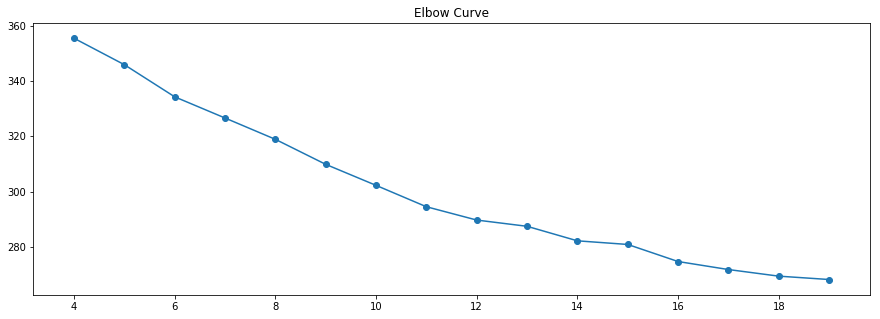

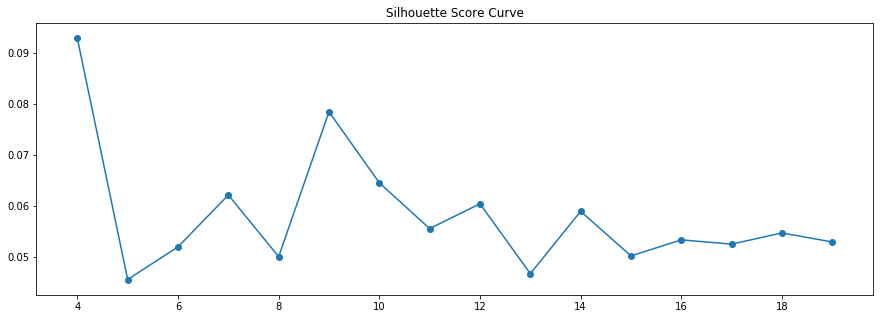

In [115]:
checkCluster(train_features_df_v7.iloc[:,:-1], _range=[4, 20])

In [116]:
train_mini_kmean_v7 = KMeans(n_clusters=6, n_init=50, max_iter=1000)

train_mini_kmean_v7_distances = train_mini_kmean_v7.fit_transform(train_features_df_v7.iloc[:,:-1])

train_features_df_v7['_class'] = train_mini_kmean_v7.labels_
np.transpose(np.unique(train_mini_kmean_v7.labels_, return_counts=True))

array([[  0,  14],
       [  1,  67],
       [  2,  92],
       [  3,  20],
       [  4, 143],
       [  5,  58]])

/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


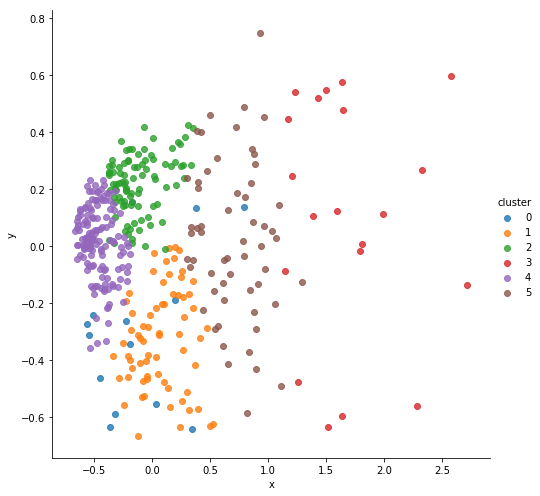

In [120]:
plotClusterPCA(train_features_df_v7.iloc[:,:-2], train_features_df_v7["_class"], size=7)

In [124]:
train_mini_kmean_v7_centers = getClusterCenter(train_mini_kmean_v7_distances, train_features_df_v7['file_names'], DATASET_PATH)
for doc in train_mini_kmean_v7_centers:
#     print(DATASET_PATH+str(doc))
    print(readFiles([doc], isRemoveSpecailchar=False, isToLower=False))
    print()
    print()

['[\'Tara and Ravi are going to the market. Amma has given them a list of fruits and vegetables to buy. At the market, Tara spots juicy red tomatoes. "I hope Amma makes tomato chutney today, " she says.Monappa, the vegetable seller, weighs everything. Into the bag goes: - 1 kg fresh red tomatoes - ½ kg onions - ½ kg potatoes - 1 coconut - 6 limes *Half is written as ½. It means one out of two equal parts of something. *A kilogram is written as kg.Tara and Ravi walk home singing: "We want . . . Tomato chutney, tomato chutney. Amma\\\'s tasty tomato chutney! "Suddenly Ravi asks Tara, "Is something dripping on your feet too? " Their bag is wet. Oh no! The tomatoes are all squashed at the bottom. Tara whispers to Ravi, "Our tomato chutney looks so horrible. Not at all like Amma\\\'s! "The next week, Tara and Ravi are careful. "Heavy vegetables at the bottom; soft and light ones on top, " Ravi keeps repeating. Into the bag goes: - 1 watermelon - ½ kg potatoes - 1 coconut - ½ kg grapes - 6 r

<h3>Save Model V7</h3>
<h4>Model Parameters Needed</h4>
<ul>
    <li>Kmeans Model for predictions</li>
    <li>TF-IDF Vectorizer</li>
    <li>PCA for Dimensionality Reduction</li>
    <li>PCA Scaler</li>
    <li>POS Tag Count Scaler</li>
</ul>
<h4>Preprocess Flow</h4>
<h6>Remove Stopwords > TF-IDF vector(1000) > PCA (50) > Count POS Tags > Words per file > Scale Pos Tags count > Scale Words per file >
    hStack all features > Predict using KMeans </h6>

In [121]:
with open("./models/model_v7/tf_idf.model", "wb") as fp:
    pkl.dump(train_vectorizer_v7, fp)
with open("./models/model_v7/pca.model", "wb") as fp:
    pkl.dump(train_pca_v7, fp)
with open("./models/model_v7/scaler_pos.model", "wb") as fp:
    pkl.dump(scalerPOSV7, fp)
with open("./models/model_v7/scaler_length.model", "wb") as fp:
    pkl.dump(scalerLenV7, fp)
with open("./models/model_v7/kmeans.model", "wb") as fp:
    pkl.dump(train_mini_kmean_v7, fp)